<a href="https://colab.research.google.com/github/dinuwanfernando/BTCUSD_model/blob/main/BTCUSD_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from math import sqrt
import matplotlib.pyplot as plt
!pip install prophet
from prophet import Prophet

In [ ]:
%pip install oandapyV20
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.contrib.requests import MarketOrderRequest
access_token = "25828916746768cb5cf6f0ec2b97218e-0b9185adf70ecd8cf1b53bb781a4b1f3"
%pip install git+https://github.com/yhilpisch/tpqoa.git
api = oandapyV20.API(access_token=access_token)

  Cloning https://github.com/yhilpisch/tpqoa.git to /tmp/pip-req-build-eum45p2p
  Running command git clone --filter=blob:none --quiet https://github.com/yhilpisch/tpqoa.git /tmp/pip-req-build-eum45p2p
  Resolved https://github.com/yhilpisch/tpqoa.git to commit 4a79f30b7095642844ef99741d9bfcb952e394db
  Preparing metadata (setup.py) ... done


In [ ]:
import tpqoa
oanda = tpqoa.tpqoa("/content/drive/MyDrive/ML BTCUSD model/oanda.cfg.txt")

In [ ]:
# Function to download historical data using Oanda API
def get_historical_data(instrument, start, end, granularity, price):
    oanda = tpqoa.tpqoa("/content/drive/MyDrive/ML BTCUSD model/oanda.cfg.txt")  # Update path if needed
    df = oanda.get_history(instrument=instrument, start=start, end=end, granularity=granularity, price=price)
    return df.dropna()


In [ ]:
date_var= '2024-04-02'

In [ ]:
df_BTC_pp_01= oanda.get_history(instrument= 'BTC_USD', start= '2014-05-07', end='2016-05-06', granularity= 'H1', price='M')
df_BTC_pp_02= oanda.get_history(instrument= 'BTC_USD', start= '2016-05-07', end='2018-05-06', granularity= 'H1', price='M')
df_BTC_pp_03= oanda.get_history(instrument= 'BTC_USD', start= '2018-05-07', end='2020-05-06', granularity= 'H1', price='M')
df_BTC_pp_04= oanda.get_history(instrument= 'BTC_USD', start= '2020-05-07', end='2022-05-06', granularity= 'H1', price='M')
df_BTC_pp_05= oanda.get_history(instrument= 'BTC_USD', start= '2022-05-07', end='2023-05-06', granularity= 'H1', price='M')
df_BTC_pp_06= oanda.get_history(instrument= 'BTC_USD', start= '2023-05-07', end='2024-01-06', granularity= 'H1', price='M')
df_BTC_pp_07= oanda.get_history(instrument= 'BTC_USD', start= '2024-01-07', end=date_var, granularity= 'H1', price='M')

In [ ]:
df_btc_p= pd.concat([df_BTC_pp_01,df_BTC_pp_02,df_BTC_pp_03,df_BTC_pp_04,df_BTC_pp_05,df_BTC_pp_06,
df_BTC_pp_07],axis=0).dropna()
df_btc_p.index= pd.to_datetime(df_btc_p.index)
df_btc_p= df_btc_p[df_btc_p.index < date_var].dropna()
###df_btc_dat.index= df_btc_data.index.date to add the time back
df_btc_p = df_btc_p.rename_axis('Date')
df_btc_p.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'btc_close','volume':'btc_volume'}, inplace=True)
df_btc_p= df_btc_p[['high','low','btc_close','btc_volume']]
df_btc_p1=df_btc_p.astype(float)
print(df_btc_p1)
df_btc_p1.dtypes

                        high      low  btc_close  btc_volume
Date                                                        
2016-01-01 06:00:00    437.0    433.0      435.5      1616.0
2016-01-01 07:00:00    437.2    434.9      435.3      1620.0
2016-01-01 08:00:00    436.8    433.3      435.5      1377.0
2016-01-01 09:00:00    435.9    434.1      434.5       868.0
2016-01-01 10:00:00    435.9    433.4      433.9       789.0
...                      ...      ...        ...         ...
2024-04-01 19:00:00  69872.7  68908.3    69705.6     17438.0
2024-04-01 20:00:00  69833.6  69367.2    69755.8     15563.0
2024-04-01 21:00:00  69951.2  69578.6    69620.8     10540.0
2024-04-01 22:00:00  69893.8  69614.4    69738.8     13519.0
2024-04-01 23:00:00  69909.6  69672.0    69686.2     11447.0

[54893 rows x 4 columns]


high          float64
low           float64
btc_close     float64
btc_volume    float64
dtype: object

In [ ]:
# Function to calculate technical indicators
def calculate_indicators(data):
    data['RSI'] = calculate_rsi(data['close'], window=14)
    #Maybe I will add more functions later with new indicators
    return data

In [ ]:
#Function to calculate rsi

def calculate_rsi(data, window=14):
    delta = data.diff()
    delta = delta[1:]  # Ignore NaN for first period
    up, down = delta.clip(lower=0), delta.clip(upper=0) * -1
    ema_up = up.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    ema_down = down.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    rs = ema_up / ema_down
    rsi = 100 - (1 / (1 + rs))
    return rsi


In [ ]:
def prepare_data(data):
    data['Date'] = pd.to_datetime(data.index)
    data.set_index('Date', inplace=True)  # Seting 'Date' as index

    # Calculate technical indicators
    data['RSI'] = calculate_rsi(data['btc_close'], window=14)  # Update column name

    # Define features and target variable
    features = ['high', 'low', 'btc_volume', 'RSI']  # Adjusting features based on indicators
    target = 'btc_close'  # Update target variable name
    return data[features], data[target]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))


In [ ]:
df_btc_p.columns

Index(['high', 'low', 'btc_close', 'btc_volume'], dtype='object')

In [ ]:
# Prepare data
#features, target = prepare_data(df_btc_p.copy())
#scaled_features = scaler.fit_transform(features)  # Apply scaling to features

In [ ]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X, y = prepare_data(df_btc_p1.copy())
scaled_features = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.2, random_state=42)



In [ ]:
# Using and training XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Define and train VAR model
#!pip install statsmodels
#from statsmodels.tsa.var import VAR
#var_model = VAR(X_train)
#var_model_fit = var_model.fit()

In [ ]:
# Using and training ARIMA model
arima_model = ARIMA(y_train, order=(5, 1, 1))
arima_model_fit = arima_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [ ]:
# Make predictions on testing set
xgb_pred = xgb_model.predict(X_test)
#var_pred = var_model_fit.forecast(steps=len(y_test))[:, 0]  # Select first column for single variable
arima_pred = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
# Evaluate model performance
def evaluate_model(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  rmse = sqrt(mse)
  print('MSE:', mse)
  print('MAE:', mae)
  print('RMSE:', rmse)


In [ ]:
print("XGBoost Model Performance:")
evaluate_model(y_test, xgb_pred)

print("\nARIMA Model Performance:")
evaluate_model(y_test, arima_pred)


XGBoost Model Performance:
MSE: 35186.597796222624
MAE: 117.76348871671824
RMSE: 187.5809099994523

ARIMA Model Performance:
MSE: 291546945.19801223
MAE: 14128.619185163328
RMSE: 17074.745831139397


In [ ]:
# Predict for future dates
future_predictions = 5
future_features = scaler.transform(prepare_data(df_btc_p1.copy().tail(future_predictions))[0])
future_pred_xgb = xgb_model.predict(future_features)
future_pred_arima = arima_model_fit.forecast(steps=future_predictions)

print("\nXGBoost Predictions for Future Dates:", future_pred_xgb)
print("ARIMA Predictions for Future Dates:", future_pred_arima)


XGBoost Predictions for Future Dates: [70924.2  70924.2  71207.1  71136.48 71207.1 ]
ARIMA Predictions for Future Dates: 43914    17014.963293
43915    16694.868585
43916    16742.609149
43917    16871.130300
43918    16832.718992
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


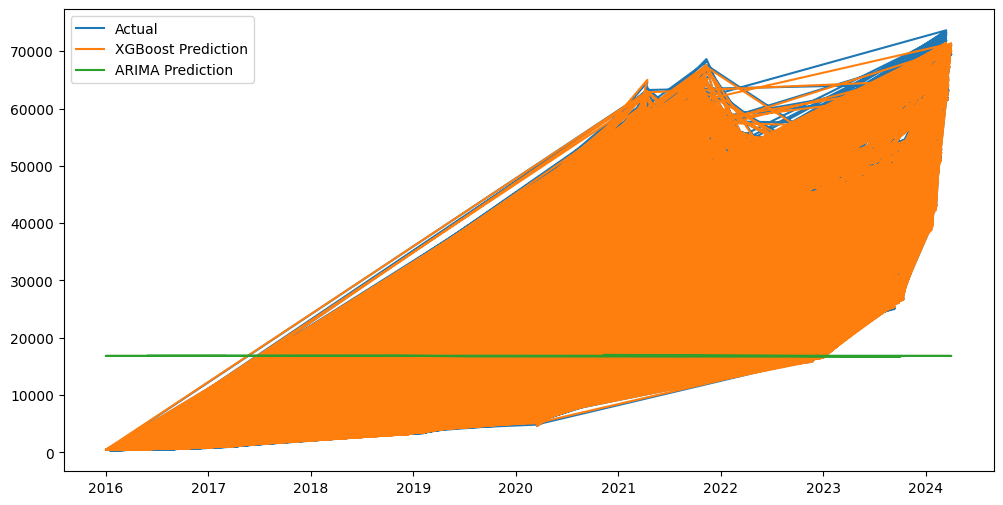

In [ ]:
# Optional: Visualize results
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, xgb_pred, label='XGBoost Prediction')
plt.plot(y_test.index, arima_pred, label='ARIMA Prediction')
plt.legend()
plt.show()

In [ ]:
# Predict for future dates (adjust number of predictions as needed)
#future_predictions = 5
#future_dates = pd.date_range(start=df_btc_p.index[-1] + pd.DateOffset(days=1), periods=future_predictions)
#future_features = scaler.transform(prepare_data(df_btc_p[future_dates.to_list()])[0])  # Assuming 'Datetime' is the index

# Make predictions using the best model (replace 'xgb_model' with your best model)
#future_pred = xgb_model.predict(future_features)

# Optional: Visualize results (replace 'y_test' with actual values if desired)
#plt.figure(figsize=(12, 6))
#plt.plot(y_test.index, y_test, label='Actual')
#plt.plot(y_test.index, xgb_pred, label='XGBoost Prediction')  # Replace with your best model's prediction
#plt.legend()
#plt.show()
